# Coursework for Artificial Intelligence M COMPSCI5087 2024-2025

## Imports

In [1]:
import os, sys
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

print("Python version:", sys.version)
print("Networkx version:", nx.__version__)
print("IPyWidgets version:", widgets.__version__)

Python version: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:29:38) [GCC 11.2.0]
Networkx version: 3.4.2
IPyWidgets version: 8.1.5


In [2]:
# To import the AIMA toolbox, add path the to the AIMA Python Toolbox folder on your system
AIMA_TOOLBOX_ROOT="/home/valeria/Documents/Code/aima-python-uofg_v20202021a"
sys.path.append(AIMA_TOOLBOX_ROOT)

import search as sch
from notebookutils import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens
# Needed to hide warnings in the matplotlib sections

In [3]:
from copy import deepcopy 
from matplotlib import lines

## Maze Definition

The following is an example of the maze with teleportation links.

You are now given the task to design an intelligent agent that can plan a route from S (with coordinates (0,0)) to G (with coordinates (1,9) ).

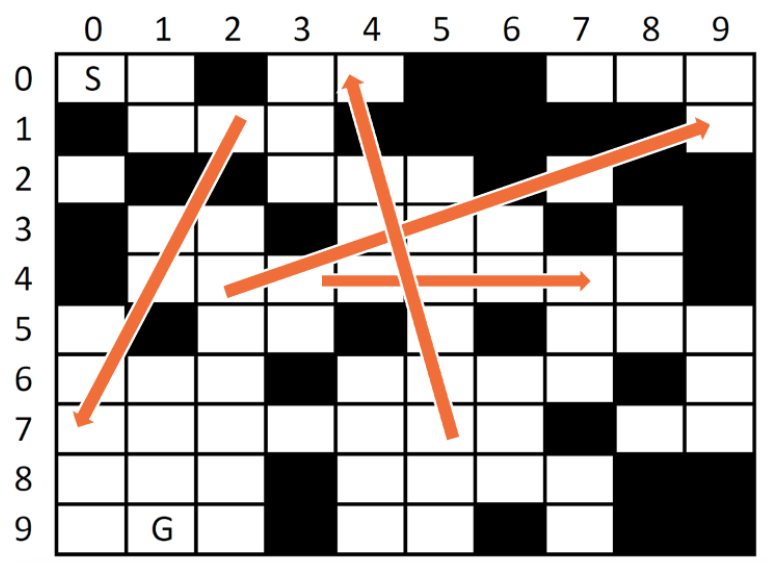
<center>Figure 1: A maze with teleportation links. Unavailable states are indicated by a black square. S is the start state. G is is the goal state.</center>

Important personal interpretation
- I am assuming that going down a teleportation link is optional: e.g. in (2,1) it's possible to go right, go left, or go down the teleportation link.
- I am assuming that the wormholes are two-ways passages: e.g. from (2,1) you can go down the teleportation link to (0,7), and from (0,7) you can go back to (2,1).


- Environment? Besides being discrete and static, it is...
    - Deterministic, because wormholes might lead to an unknown state, but they always lead to the same state with 100% probability.
    - Partially observable, because it is not known from the percepts where the "teleport" action is going to take the agent.
- Actuators? Move the agent according to 5 possible actions:
    - Left
    - Right
    - Up
    - Down
    - Teleport
- Percepts? 
    - Current x,y location
    - Feasibility of all 5 actions, expressed by booleans (l,r,u,d,t)
- Sensors? Incomplete because...
    - The agent knows to which state the (Left, Right, Up, Down) actions take it
    - But the agent does not know to which state the (Teleport) action takes it
- Performance measure? The sortest the path to goal, the better (in terms of steps taken from the start point)

### Graph representation

#### States and actions definitions

`S_08_00=dict(S_09_00=1,S_07_00=1)` means that we have a unique state "S_08_00" from which you can get to S_09_00 and S_07_00 with cost 1.

In [4]:
maze_map = sch.UndirectedGraph(dict(
    S_00_00=dict(S_01_00=1),
    S_01_00=dict(S_01_01=1,S_01_00=1),
    S_03_00=dict(S_04_00=1,S_03_01=1),
    S_04_00=dict(S_03_00=1),
    S_07_00=dict(S_08_00=1),
    S_08_00=dict(S_09_00=1,S_07_00=1),
    S_09_00=dict(S_08_00=1,S_09_01=1),
    S_01_01=dict(S_01_00=1,S_02_01=1),
    S_02_01=dict(S_01_01=1,S_03_01=1,S_00_07=1), # Wormhole
    S_03_01=dict(S_03_00=1,S_03_02=1),
    S_09_01=dict(S_09_00=1),
    S_03_02=dict(S_03_01=1,S_04_02=1),
    S_04_02=dict(S_03_02=1,S_05_02=1,S_04_03=1),
    S_05_02=dict(S_04_02=1,S_05_03=1),
    S_01_03=dict(S_01_04=1,S_02_03=1),
    S_02_03=dict(S_01_03=1,S_02_04=1),
    S_04_03=dict(S_04_02=1,S_05_03=1,S_04_04=1),
    S_05_03=dict(S_05_02=1,S_06_03=1,S_04_03=1,S_05_04=1),
    S_06_03=dict(S_05_03=1,S_06_04=1),
    S_08_03=dict(S_08_04=1),
    S_01_04=dict(S_01_03=1,S_02_04=1),
    S_02_04=dict(S_01_04=1,S_02_05=1,S_02_03=1,S_03_04=1,S_09_01=1), # Wormhole
    S_03_04=dict(S_03_05=1,S_02_04=1,S_04_04=1,S_07_04=1),
    S_04_04=dict(S_04_03=1,S_03_04=1,S_05_04=1),
    S_05_04=dict(S_04_04=1,S_05_05=1,S_06_04=1,S_05_03=1),
    S_06_04=dict(S_06_03=1,S_07_04=1,S_05_04=1),
    S_07_04=dict(S_06_04=1,S_07_05=1,S_08_04=1),
    S_08_04=dict(S_07_04=1,S_08_03=1,S_08_05=1),
    S_00_05=dict(S_00_06=1),
    S_02_05=dict(S_02_06=1,S_02_04=1,S_03_05=1),
    S_03_05=dict(S_02_05=1,S_03_04=1),
    S_05_05=dict(S_05_04=1,S_05_06=1),
    S_07_05=dict(S_08_05=1,S_07_04=1,S_07_06=1),
    S_08_05=dict(S_09_05=1,S_07_05=1,S_08_04=1),
    S_09_05=dict(S_09_06=1,S_08_05=1),
    S_00_06=dict(S_00_07=1,S_00_05=1,S_01_06=1),
    S_01_06=dict(S_00_06=1,S_01_07=1,S_02_06=1),
    S_02_06=dict(S_02_07=1,S_02_05=1,S_01_06=1),
    S_04_06=dict(S_05_06=1,S_04_07=1),
    S_05_06=dict(S_04_06=1,S_06_06=1,S_05_05=1,S_05_07=1),
    S_06_06=dict(S_07_06=1,S_06_07=1,S_05_06=1),
    S_07_06=dict(S_06_06=1,S_07_05=1),
    S_09_06=dict(S_09_05=1,S_09_07=1),
    S_00_07=dict(S_00_08=1,S_01_07=1,S_00_06=1),
    S_01_07=dict(S_00_07=1,S_02_07=1,S_01_08=1,S_01_06=1),
    S_02_07=dict(S_01_07=1,S_03_07=1,S_02_06=1,S_02_08=1),
    S_03_07=dict(S_04_07=1,S_02_07=1),
    S_04_07=dict(S_03_07=1,S_05_07=1,S_04_08=1,S_04_06=1),
    S_05_07=dict(S_04_07=1,S_06_07=1,S_05_08=1,S_05_06=1,S_04_00=1),
    S_06_07=dict(S_06_06=1,S_06_08=1,S_05_07=1),
    S_08_07=dict(S_09_07=1),
    S_09_07=dict(S_08_07=1,S_09_06=1),
    S_00_08=dict(S_00_09=1,S_01_08=1,S_00_07=1),
    S_01_08=dict(S_00_08=1,S_02_08=1,S_01_09=1,S_01_07=1),
    S_02_08=dict(S_02_09=1,S_02_07=1,S_01_08=1),
    S_04_08=dict(S_04_09=1,S_05_08=1,S_04_07=1),
    S_05_08=dict(S_04_08=1,S_06_08=1,S_05_09=1,S_05_07=1),
    S_06_08=dict(S_07_08=1,S_06_07=1,S_05_08=1),
    S_07_08=dict(S_07_09=1,S_06_08=1),
    S_01_09=dict(S_01_08=1),
    S_00_09=dict(S_01_09=1,S_00_08=1),
    S_02_09=dict(S_01_09=1,S_02_08=1),
    S_04_09=dict(S_04_08=1,S_05_09=1),
    S_05_09=dict(S_05_08=1,S_04_09=1),
    S_07_09=dict(S_07_08=1)))

In [5]:
maze_map.locations = dict(
    S_00_00=(0,0),
    S_01_00=(1,0),
    S_03_00=(3,0),
    S_04_00=(4,0),
    S_07_00=(7,0),
    S_08_00=(8,0),
    S_09_00=(9,0),
    S_01_01=(1,1),
    S_02_01=(2,1),
    S_03_01=(3,1),
    S_09_01=(9,1),
    S_03_02=(3,2),
    S_04_02=(4,2),
    S_05_02=(5,2),
    S_01_03=(1,3),
    S_02_03=(2,3),
    S_04_03=(4,3),
    S_05_03=(5,3),
    S_06_03=(6,3),
    S_08_03=(8,3),
    S_01_04=(1,4),
    S_02_04=(2,4),
    S_03_04=(3,4),
    S_04_04=(4,4),
    S_05_04=(5,4),
    S_06_04=(6,4),
    S_07_04=(7,4),
    S_08_04=(8,4),
    S_00_05=(0,5),
    S_02_05=(2,5),
    S_03_05=(3,5),
    S_05_05=(5,5),
    S_07_05=(7,5),
    S_08_05=(8,5),
    S_09_05=(9,5),
    S_00_06=(0,6),
    S_01_06=(1,6),
    S_02_06=(2,6),
    S_04_06=(4,6),
    S_05_06=(5,6),
    S_06_06=(6,6),
    S_07_06=(7,6),
    S_09_06=(9,6),
    S_00_07=(0,7),
    S_01_07=(1,7),
    S_02_07=(2,7),
    S_03_07=(3,7),
    S_04_07=(4,7),
    S_05_07=(5,7),
    S_06_07=(6,7),
    S_08_07=(8,7),
    S_09_07=(9,7),
    S_00_08=(0,8),
    S_01_08=(1,8),
    S_02_08=(2,8),
    S_04_08=(4,8),
    S_05_08=(5,8),
    S_06_08=(6,8),
    S_07_08=(7,8),
    S_00_09=(0,9),
    S_01_09=(1,9),
    S_02_09=(2,9),
    S_04_09=(4,9),
    S_05_09=(5,9),
    S_07_09=(7,9))

maze_map_locations = maze_map.locations

In [6]:
print("Unique states/nodes (i.e.locations) and possible actions in those states:\n") 
print(maze_map.locations) 

Unique states/nodes (i.e.locations) and possible actions in those states:

{'S_00_00': (0, 0), 'S_01_00': (1, 0), 'S_03_00': (3, 0), 'S_04_00': (4, 0), 'S_07_00': (7, 0), 'S_08_00': (8, 0), 'S_09_00': (9, 0), 'S_01_01': (1, 1), 'S_02_01': (2, 1), 'S_03_01': (3, 1), 'S_09_01': (9, 1), 'S_03_02': (3, 2), 'S_04_02': (4, 2), 'S_05_02': (5, 2), 'S_01_03': (1, 3), 'S_02_03': (2, 3), 'S_04_03': (4, 3), 'S_05_03': (5, 3), 'S_06_03': (6, 3), 'S_08_03': (8, 3), 'S_01_04': (1, 4), 'S_02_04': (2, 4), 'S_03_04': (3, 4), 'S_04_04': (4, 4), 'S_05_04': (5, 4), 'S_06_04': (6, 4), 'S_07_04': (7, 4), 'S_08_04': (8, 4), 'S_00_05': (0, 5), 'S_02_05': (2, 5), 'S_03_05': (3, 5), 'S_05_05': (5, 5), 'S_07_05': (7, 5), 'S_08_05': (8, 5), 'S_09_05': (9, 5), 'S_00_06': (0, 6), 'S_01_06': (1, 6), 'S_02_06': (2, 6), 'S_04_06': (4, 6), 'S_05_06': (5, 6), 'S_06_06': (6, 6), 'S_07_06': (7, 6), 'S_09_06': (9, 6), 'S_00_07': (0, 7), 'S_01_07': (1, 7), 'S_02_07': (2, 7), 'S_03_07': (3, 7), 'S_04_07': (4, 7), 'S_05_07': (

### Visualization

In [7]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in maze_map.locations.keys()}
node_positions = maze_map.locations
node_label_pos = { k:[v[0],v[1]-.3]  for k,v in maze_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in maze_map.graph_dict.items() for k2, v2 in v.items()}

maze_graph_data = {  'graph_dict' : maze_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                        'edge_weights': edge_weights
                     }

print("Done creating the graph object")

Done creating the graph object


----

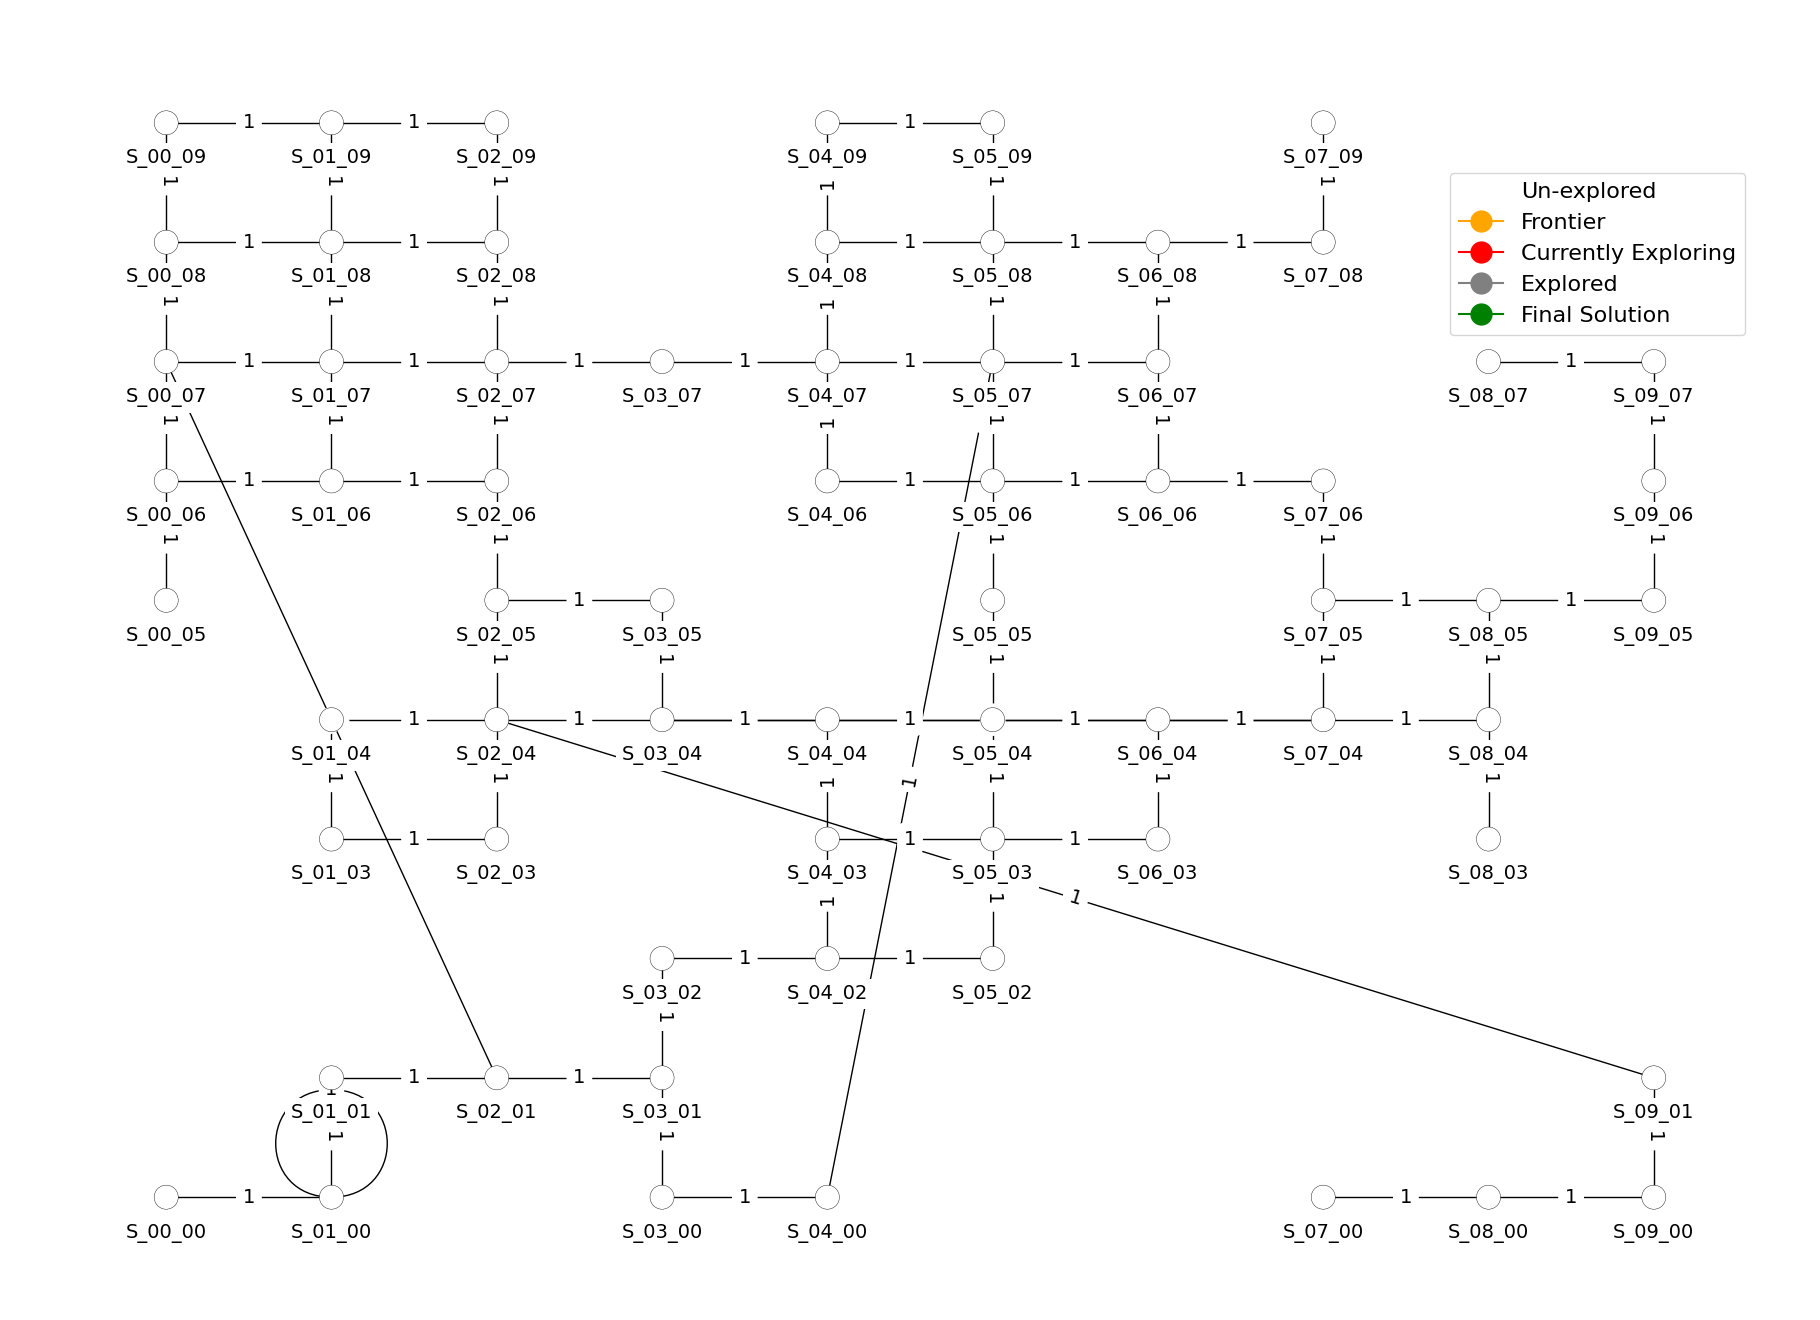

In [8]:
show_map(maze_graph_data)

## Solving the problem

Now that the graph/map has been completed in Q3.1.6 (c), we will try to use A-star to find a viable path.

### Define the problem using the AIMA toolbox

In [9]:
maze_problem = sch.GraphProblem('S_00_00', 'S_01_09', maze_map)

print("Initial state: " + maze_problem.initial)
print("Goal state: "    + maze_problem.goal)

Initial state: S_00_00
Goal state: S_01_09


### Define the A-star search function

The cells below copy the A* implementation from Lab 3, using a helper functions from the AIMA toolbox.

According to the current setup...
- Heuristic function h = Euclidian distance to the maze exit
- Cost function f = Uniform, weighted 1 for everything according to the network definition

Since the weights are uniform, this algorithm is efectively running a greedy best first search that minimizes h


In [10]:
def my_best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = sch.memoize(f, 'f')
    node = sch.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = sch.PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None


In [11]:
def my_astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = sch.memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = my_best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

### Run the solver

In [12]:
all_node_colors=[]
iterations, all_node_colors, node = my_astar_search_graph(problem=maze_problem, h=None)

#-- Trace the solution --#
solution_path = [node]
cnode = node.parent
solution_path.append(cnode)
while cnode.state != "S_00_00":    
    cnode = cnode.parent  
    solution_path.append(cnode)

print("----------------------------------------")
print("Identified goal state:"+str(solution_path[0]))
print("----------------------------------------")
print("Solution trace:"+str(solution_path))
print("----------------------------------------")


----------------------------------------
Identified goal state:<Node S_01_09>
----------------------------------------
Solution trace:[<Node S_01_09>, <Node S_00_09>, <Node S_00_08>, <Node S_00_07>, <Node S_02_01>, <Node S_01_01>, <Node S_01_00>, <Node S_00_00>]
----------------------------------------


### Visualization

In [13]:
do_full_visualization = True
if do_full_visualization:     
    # WARNING the FULL visualisation might not work very well on some computers due to 
    # the large graph and the many iterations required.The visualisaiton will 
    # typically compute the solution and do the plotting at the end - and it often takes a long time ...
    #
    print("::: Full Visualization ::::")
    all_node_colors = []        
    display_visual(maze_graph_data, user_input=False, 
               algorithm=my_astar_search_graph, 
               problem=maze_problem)

::: Full Visualization ::::


interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

#### Analysis

The solution found is the optimal one. There is one more optimal solution, the one going through 01_07 and 01_08 instead of 00_08 and 00_09.